# Information Visualization - Exercise 1

The purpose of this exercise is to develop skills in working with raw data, as well as in data imputation and cleaning. These are crucial tasks for anyone involved in data analysis or machine learning, as the quality of the data you work with can have a significant impact on the accuracy of your results.
To start, we will be using a provided CSV file that contains information about agriculture in different countries around the world. This file may be messy and unstructured, which is a common scenario when dealing with real-world data. Therefore, we will need to employ various techniques to clean and prepare the data for analysis.

In [2]:
# imports
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer

import plotly.express as px

import json
import string
import os

In [3]:
# installs
# !pip install numpy matplotlib pandas missingno

# data preparation

In [3]:
datapath = './data'
fileName = 'agriRuralDevelopment-2.csv'

df_oig = pd.read_csv(os.path.join(datapath, fileName), index_col=False)

## removing aggregated values

In [4]:
shape_before = df_oig.shape
aggregated_list = ["Arab World" ,
        "Caribbean small states", 
        "Central Europe and the Baltics", 
        "East Asia & Pacific",
        "European Union",
        "Europe & Central Asia",
        "Latin America & Caribbean",
        "Middle East & North Africa",
        "North America",
        "Small states",
        "South Asia",
        "Sub-Saharan Africa",
        "World"
        ]

df = df_oig.loc[df_oig["Country Name"].apply(lambda x : x not in aggregated_list)].reset_index(drop = True)
df.head()
shape_after = df.shape

print(shape_before, shape_after, shape_before[0] - shape_after[0])

(13908, 55) (13115, 55) 793


One of the first steps in this process will be to identify and remove any rows that contain aggregated values. Aggregated values represent data that has been combined or summarized in some way, such as by averaging or summing. While this information can be useful in certain contexts, for our purposes we are only interested in the individual countries. Therefore, we will drop these rows to ensure that we are working exclusively with country-level data.

<AxesSubplot: >

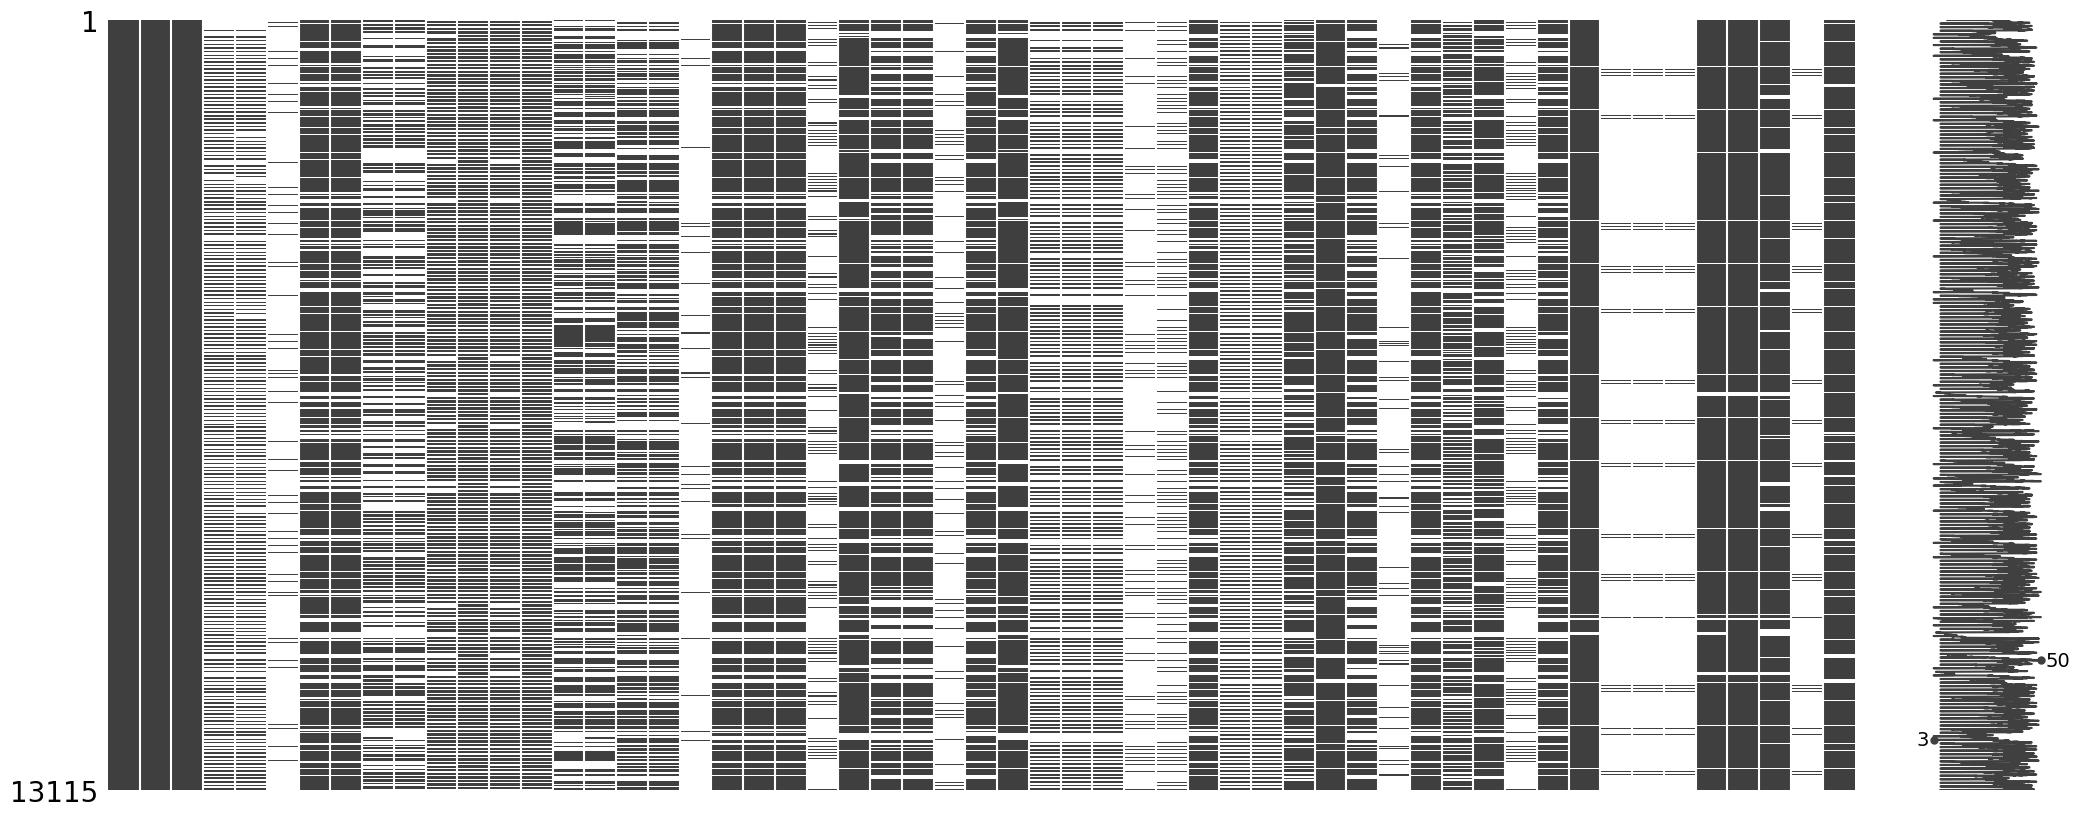

In [5]:
msno.matrix(df)

## selecting well represented columns

In the code snippet above, we are utilizing the missingno package to generate a matrix that visually represents the missing values in our data. This matrix uses white spaces to indicate missing values, making it easy to identify which attributes or columns have the most missing data.
As we can see from the matrix, some columns only have a few values available for analysis. In such cases, imputing missing values may not be a viable option as we have too little information to make accurate predictions. This can be problematic for data analysis and modeling, as missing data can significantly impact the accuracy and validity of our results.
Therefore, we drop columns with more than 30% of NaNs. This threshold was chosen as it strikes a balance between preserving data while ensuring that we are not working with attributes that have a significant amount of missing information.

<AxesSubplot: >

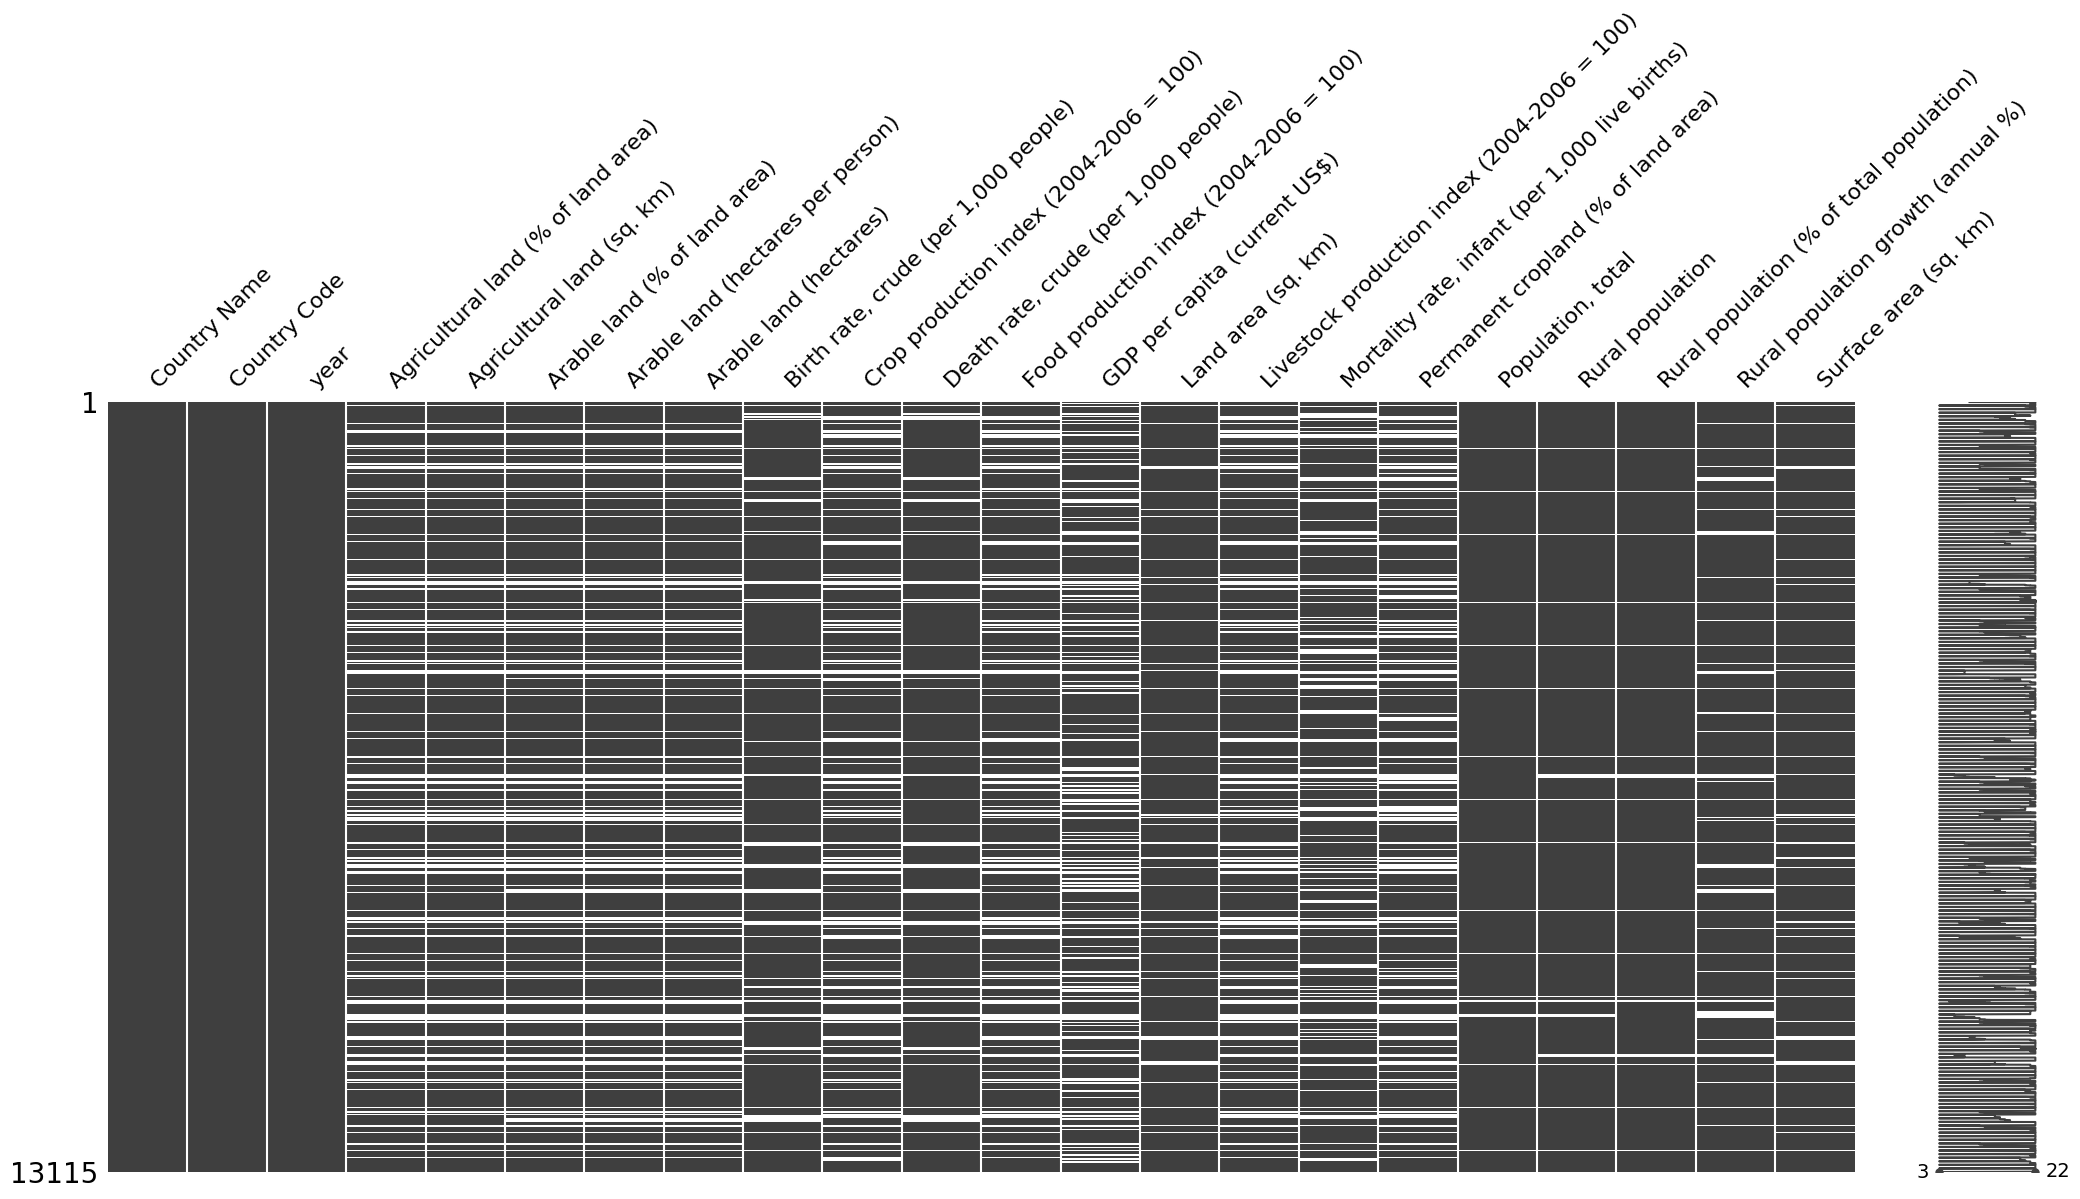

In [6]:
criteria = df[:].isna().sum() < 13115 * 0.3 # allowed nans
df_selected = df[criteria.index[criteria]]
msno.matrix(df_selected)

<AxesSubplot: >

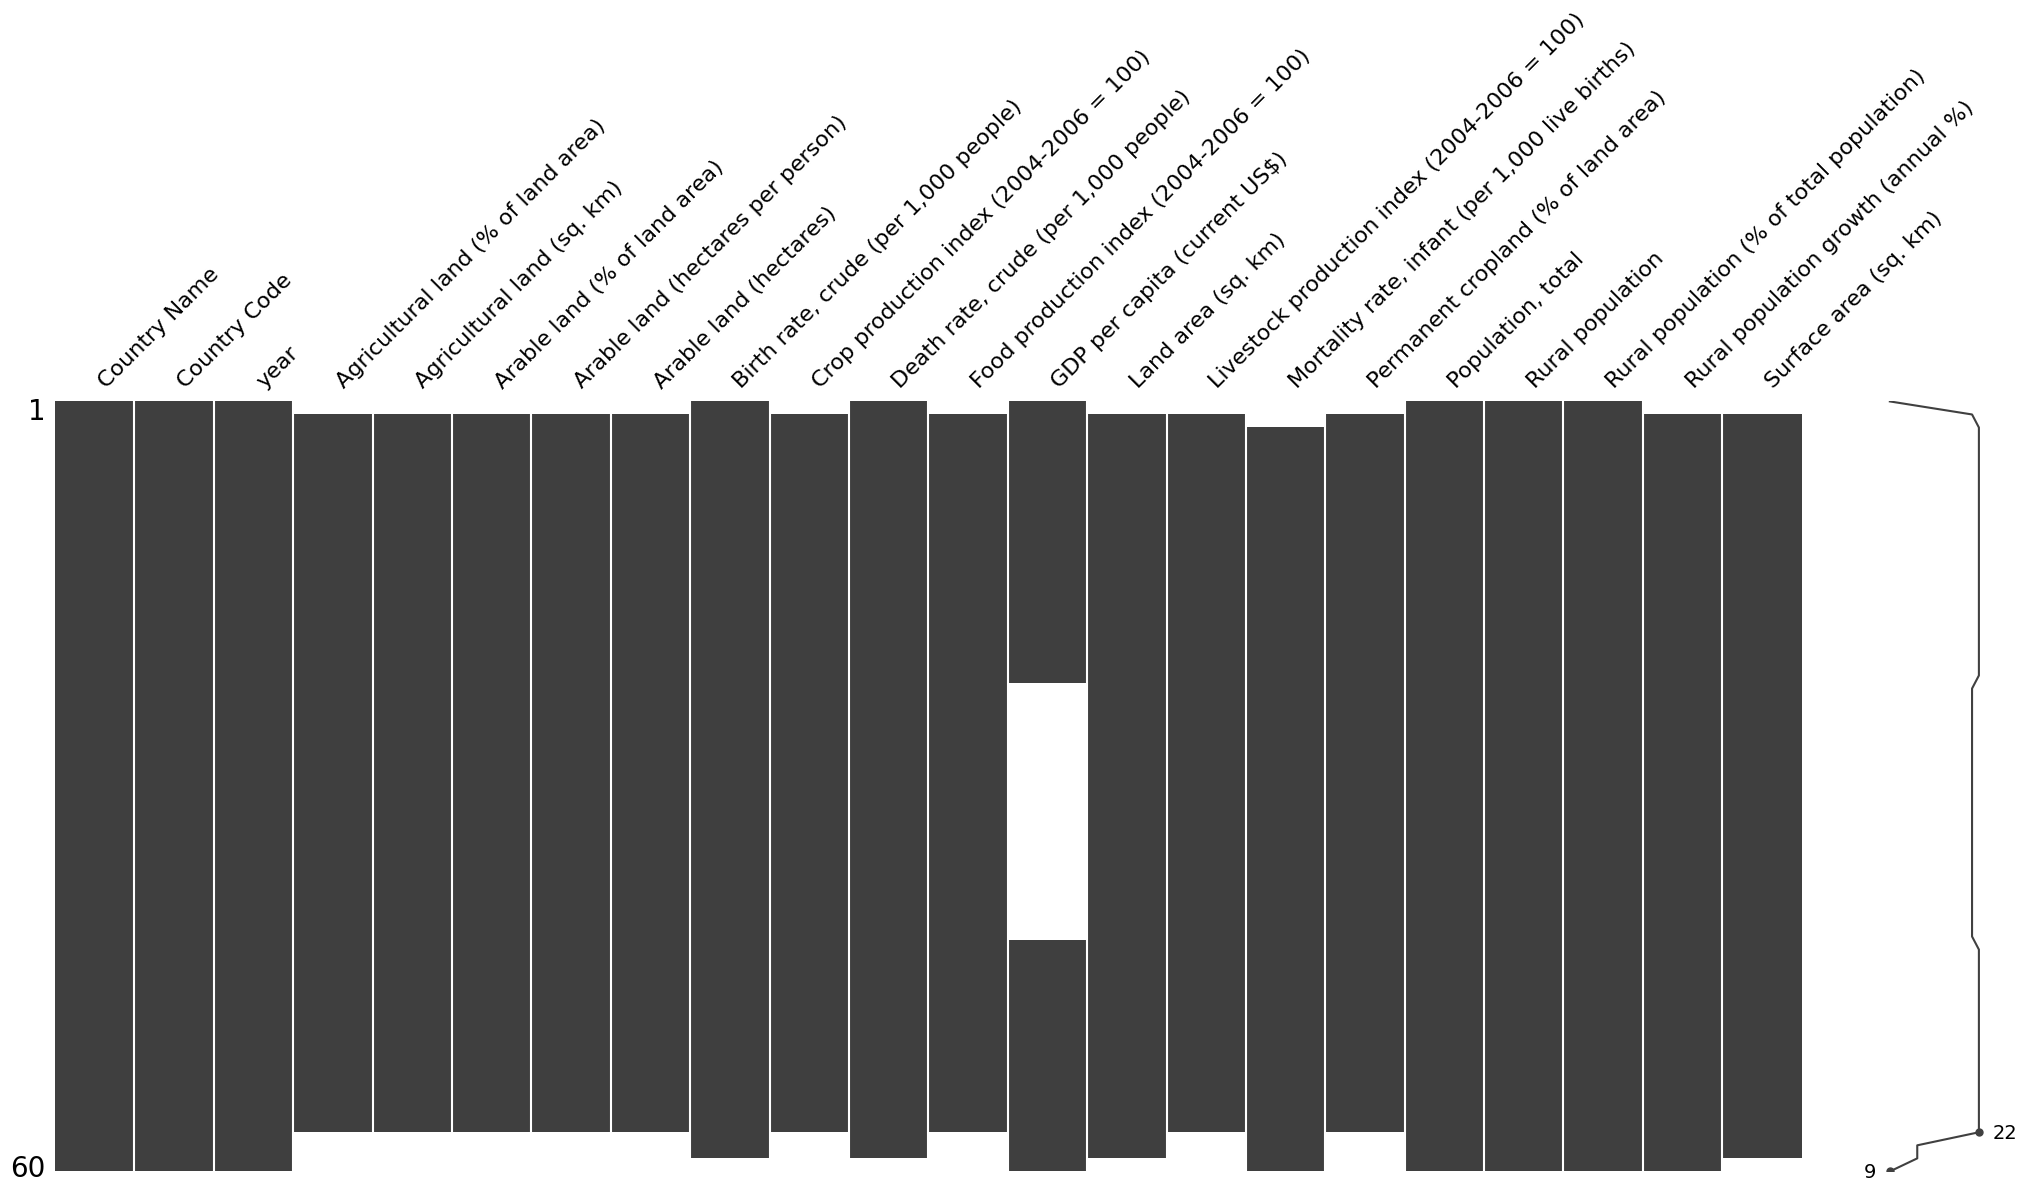

In [7]:
df_selected.iloc[0:60]["Country Name"]
sample_df = df_selected.iloc[0:60]
msno.matrix(sample_df)

In [8]:
def myImputationFunction(colm):
    sol = colm.interpolate(method='linear')
    sol = sol[::-1]
    sol = sol.interpolate(method='linear')
    sol = sol[::-1]
    colm = sol
    return colm

<AxesSubplot: >

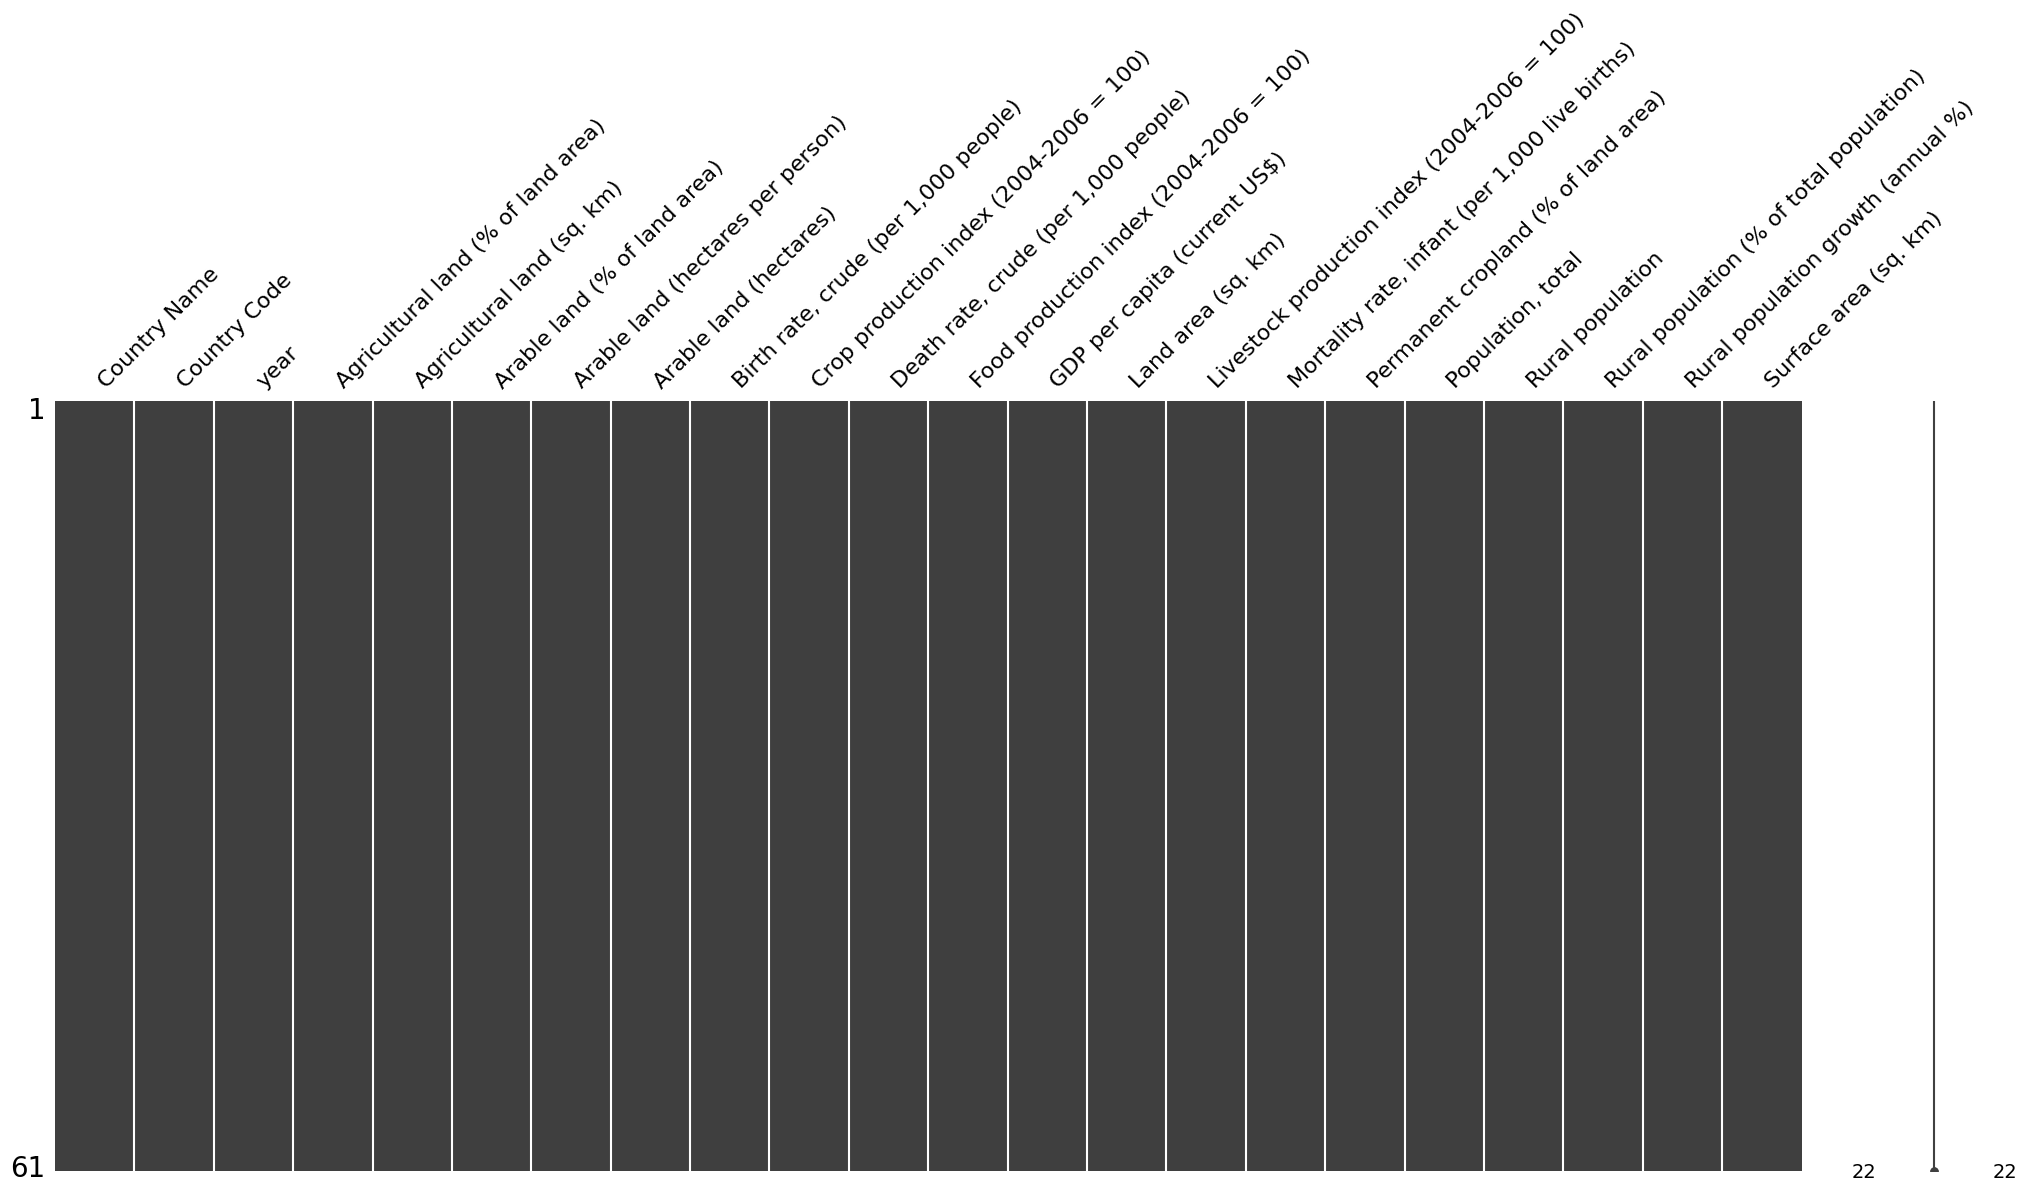

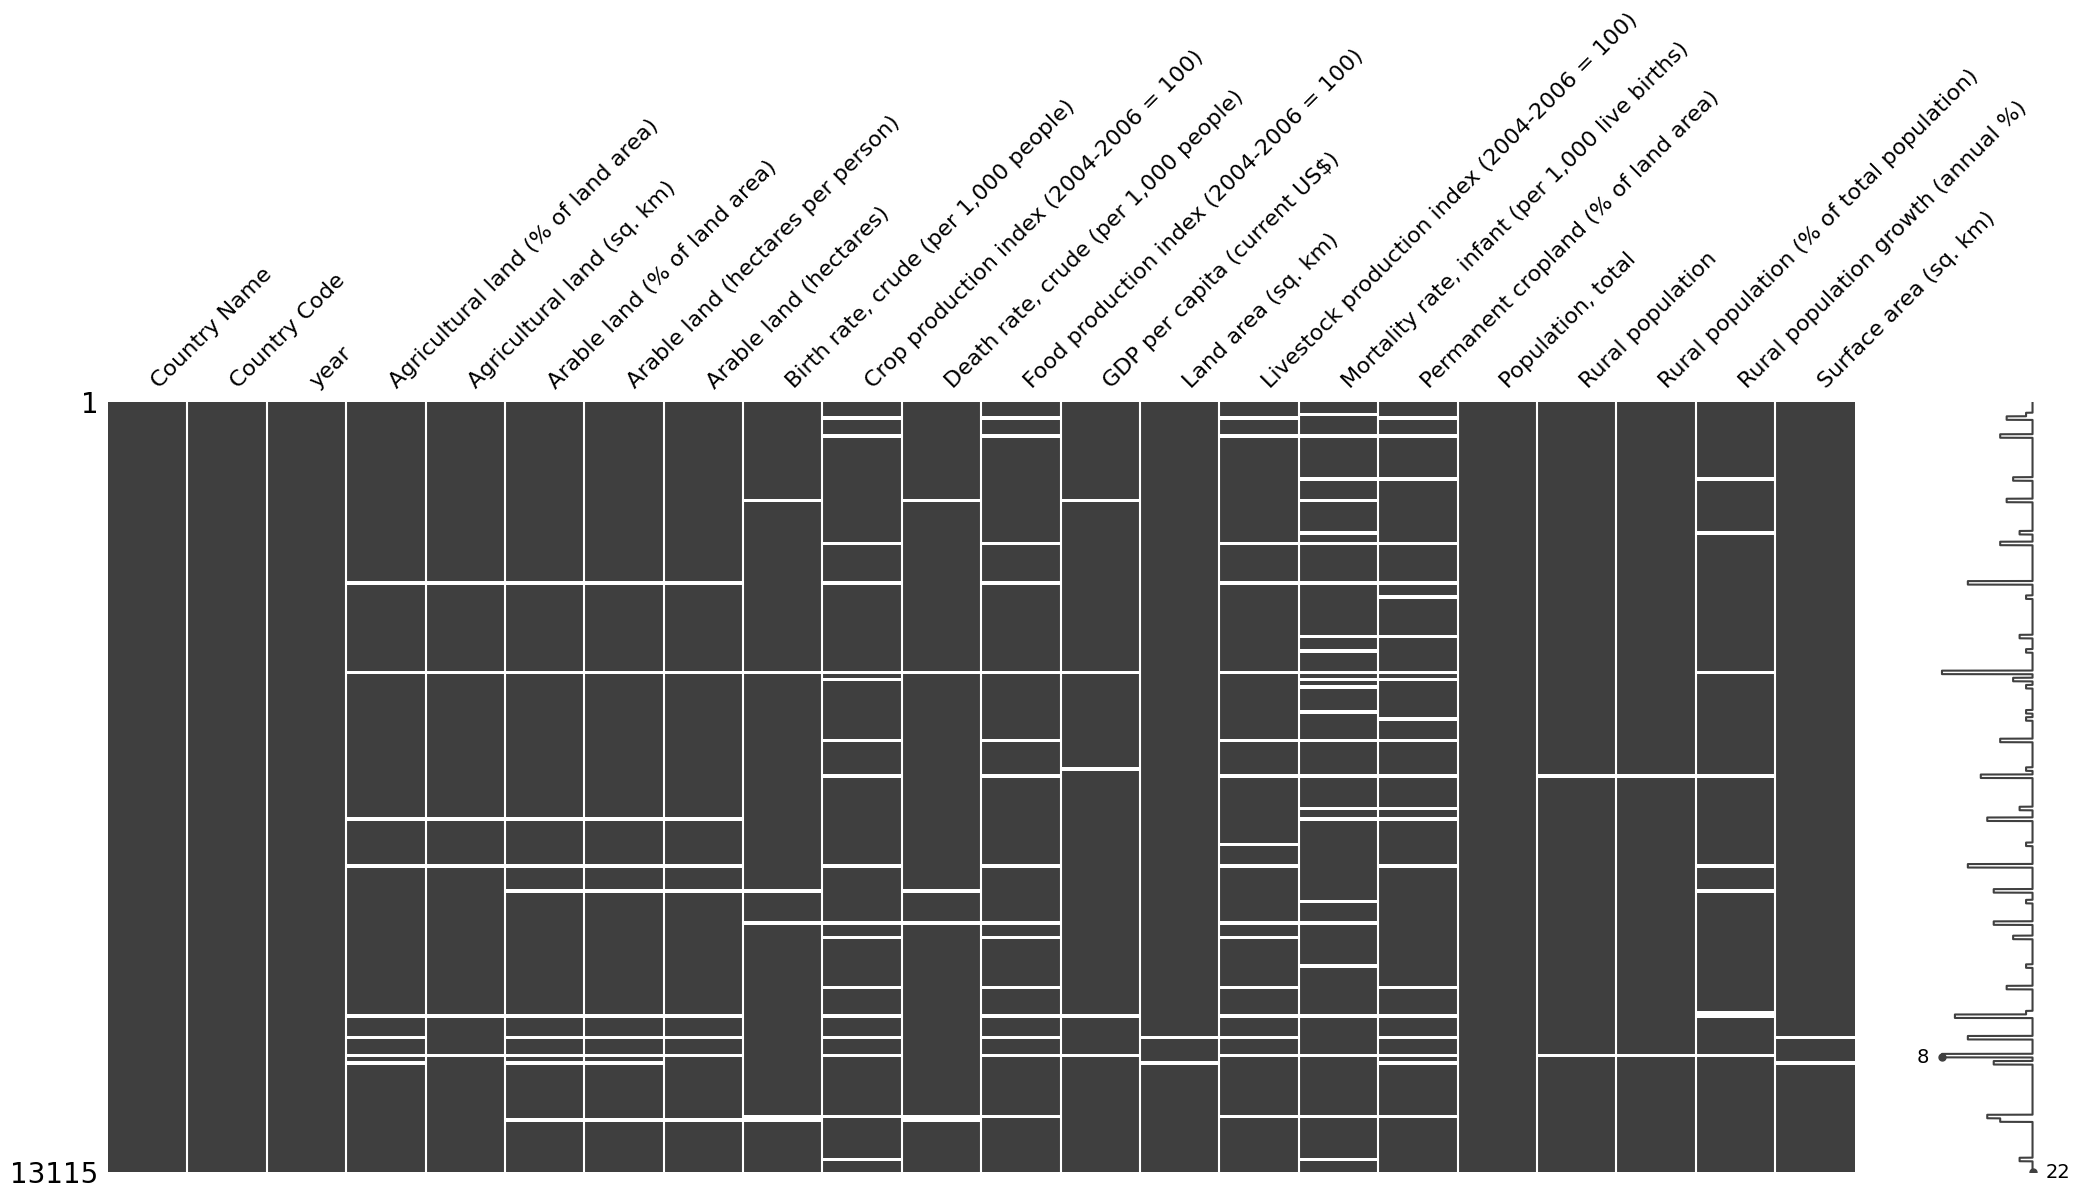

In [9]:

df_imputed = df_selected.copy()

country_names = sorted(list(set(df_imputed["Country Name"])))
for cn in country_names:
    selected = df_imputed.loc[df_imputed["Country Name"] == cn,:]
    solution = df_imputed.loc[df_imputed["Country Name"] == cn,:].apply(lambda x: myImputationFunction(x), axis=0)
    df_imputed.loc[df_imputed["Country Name"] == cn,:] = solution

msno.matrix(df_imputed.loc[df_imputed["Country Name"] == country_names[0],:])
msno.matrix(df_imputed)

To ensure that our imputation method would not use data from one country to fill in missing values for another, we first grouped our data by country. This approach ensured that the imputation method would only use data from the same country to fill in missing values, preserving the integrity of our data.
While the mean imputation method can be a suitable option for some types of data, it may not be the best approach for data that varies significantly over time. In our case, we were analyzing changes in agricultural data over multiple years, making the mean imputation method less appropriate for our needs.
As such, we initially chose to work with the K-Nearest Neighbors (KNN) imputation method from the scikit-learn library. This method involves filling in missing values with the average of values from the K most similar data points. However, after implementing this method, we noticed that it made some questionable choices when filling in missing values.
In the end, we decided to use the interpolate() function from the pandas package. This method involves filling in missing values by interpolating between existing values. We were unfortunately not successful to impute all of our data, however, it was enough to work with for now.

In [11]:
# df_imputed.to_csv("claras_dataframe.csv")

# Data Imputation Visualization

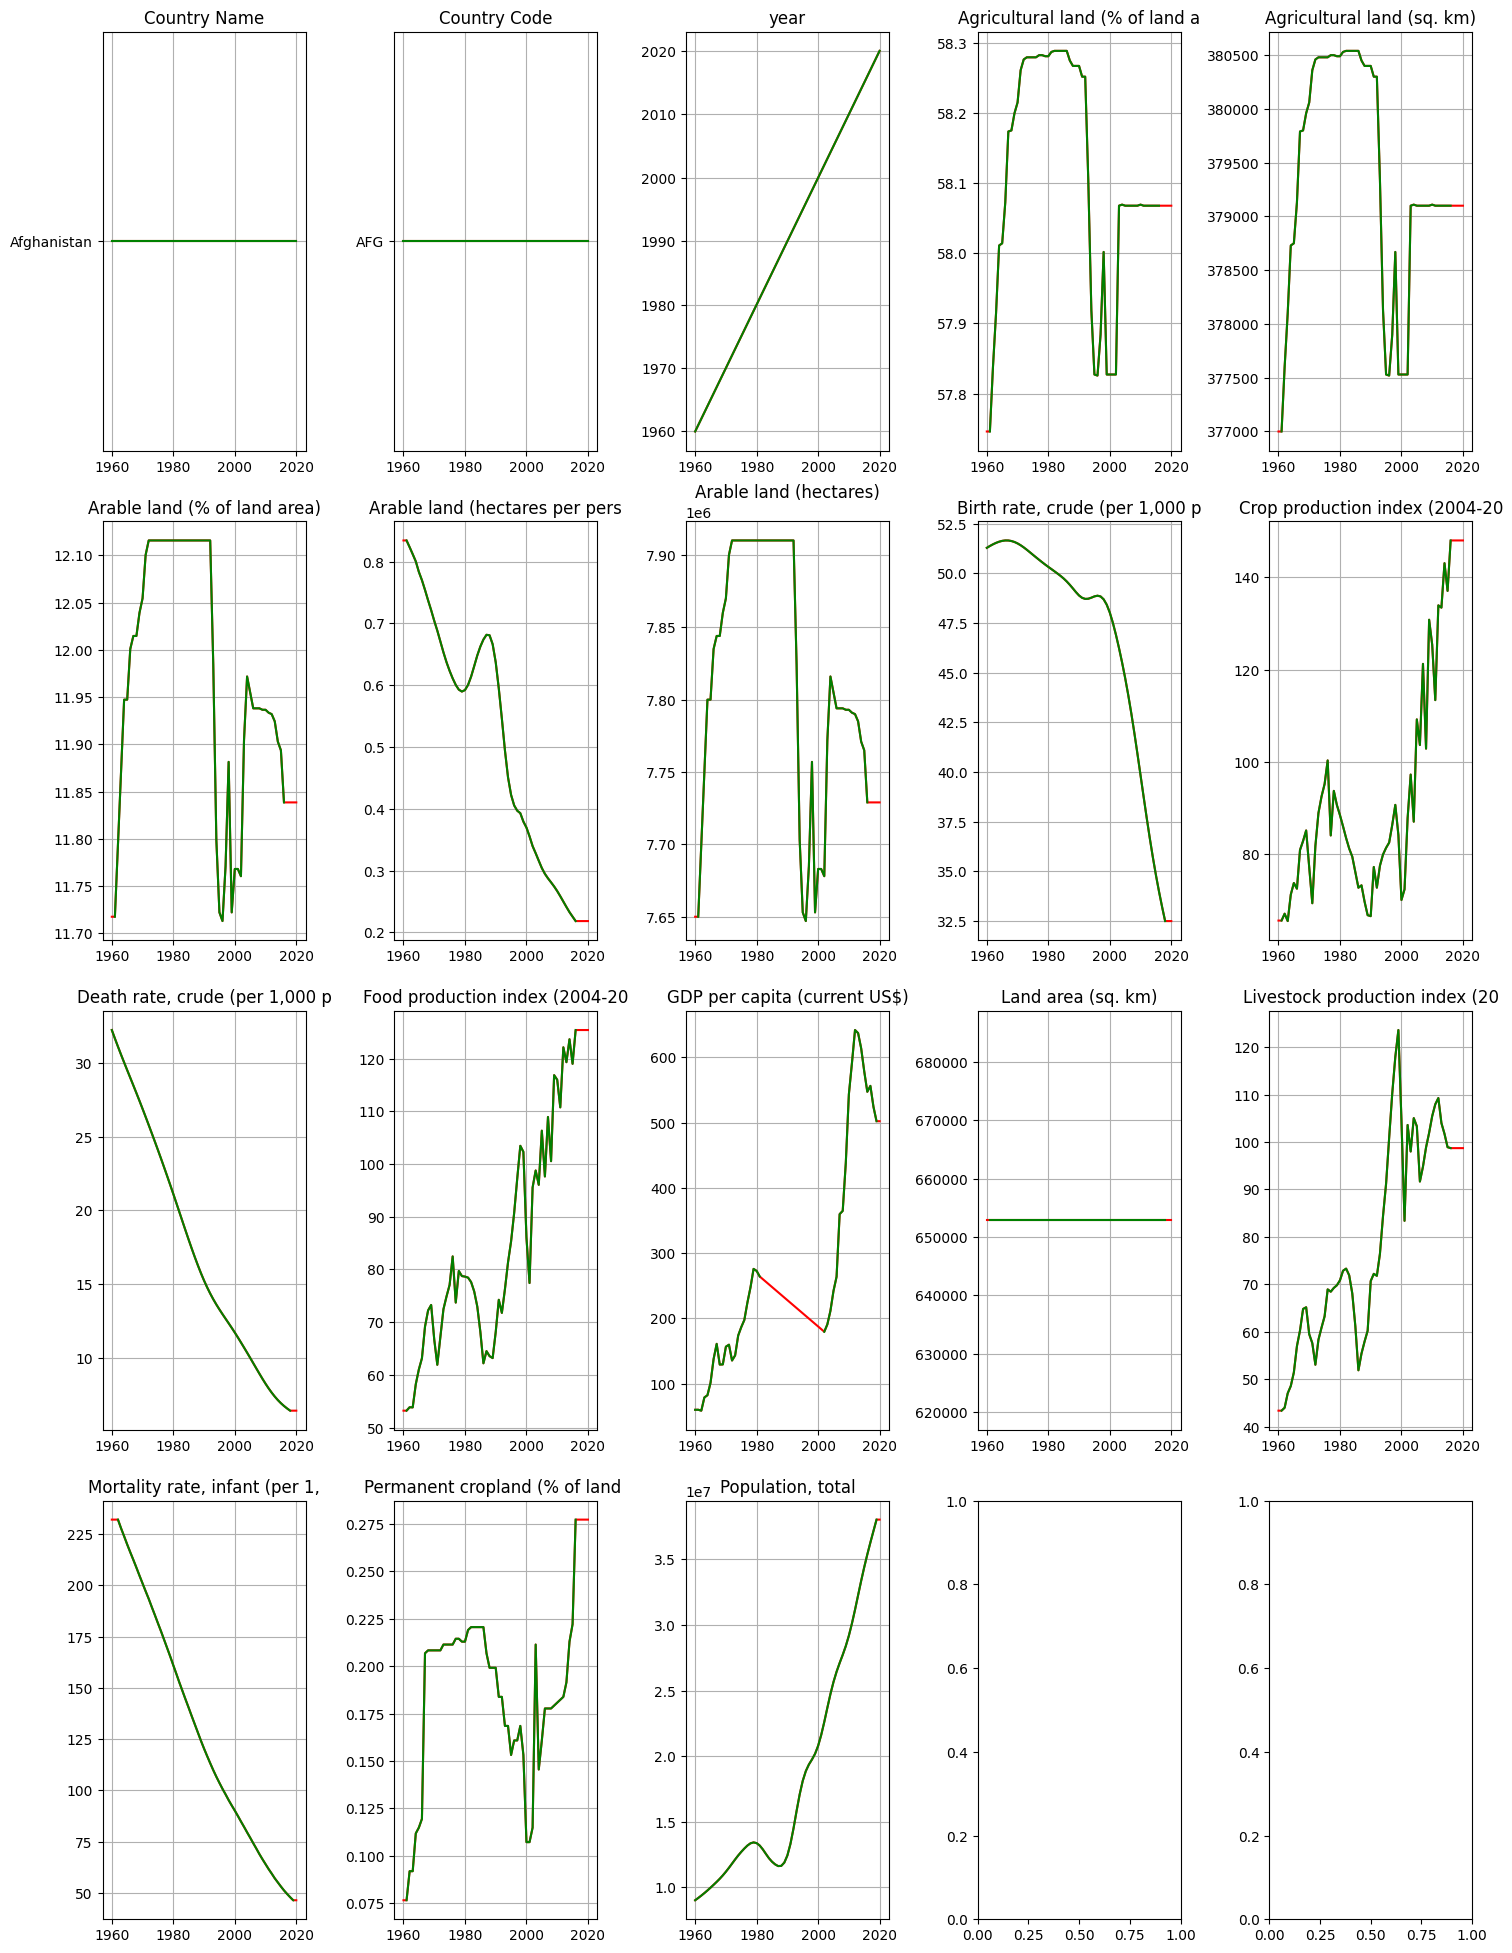

In [10]:
country = country_names[0]
df_country_oig = df_selected.loc[df_selected["Country Name"] == country,:]
df_country_imputed = df_imputed.loc[df_imputed["Country Name"] == country,:]

time = df_country_imputed.iloc[:,2]
names = df_country_imputed.columns.values

fig, axs = plt.subplots(4,5, figsize=(15,20))
fig.tight_layout(pad=3.0)
for i, nam in enumerate(names[3:-1]):
    ax = axs[i//5, i%5]
    ax.set_title(names[i][0:30])
    ax.plot(time, df_country_imputed.iloc[:,i], color='red')
    ax.plot(time, df_country_oig.iloc[:,i], color='green')
    ax.set_axisbelow(True)
    ax.grid()


To test how well our data imputation works we first only considered one country, Afganistan. The green line represents the original data set and the red line represents the imputed data. For the attribute GDP per capita, we observe a big chunk of data was missing before, however, the data imputation method successfully filled in the missing values.

# Data Distribution Visualisation

In [15]:
df_oig.shape

(13908, 55)

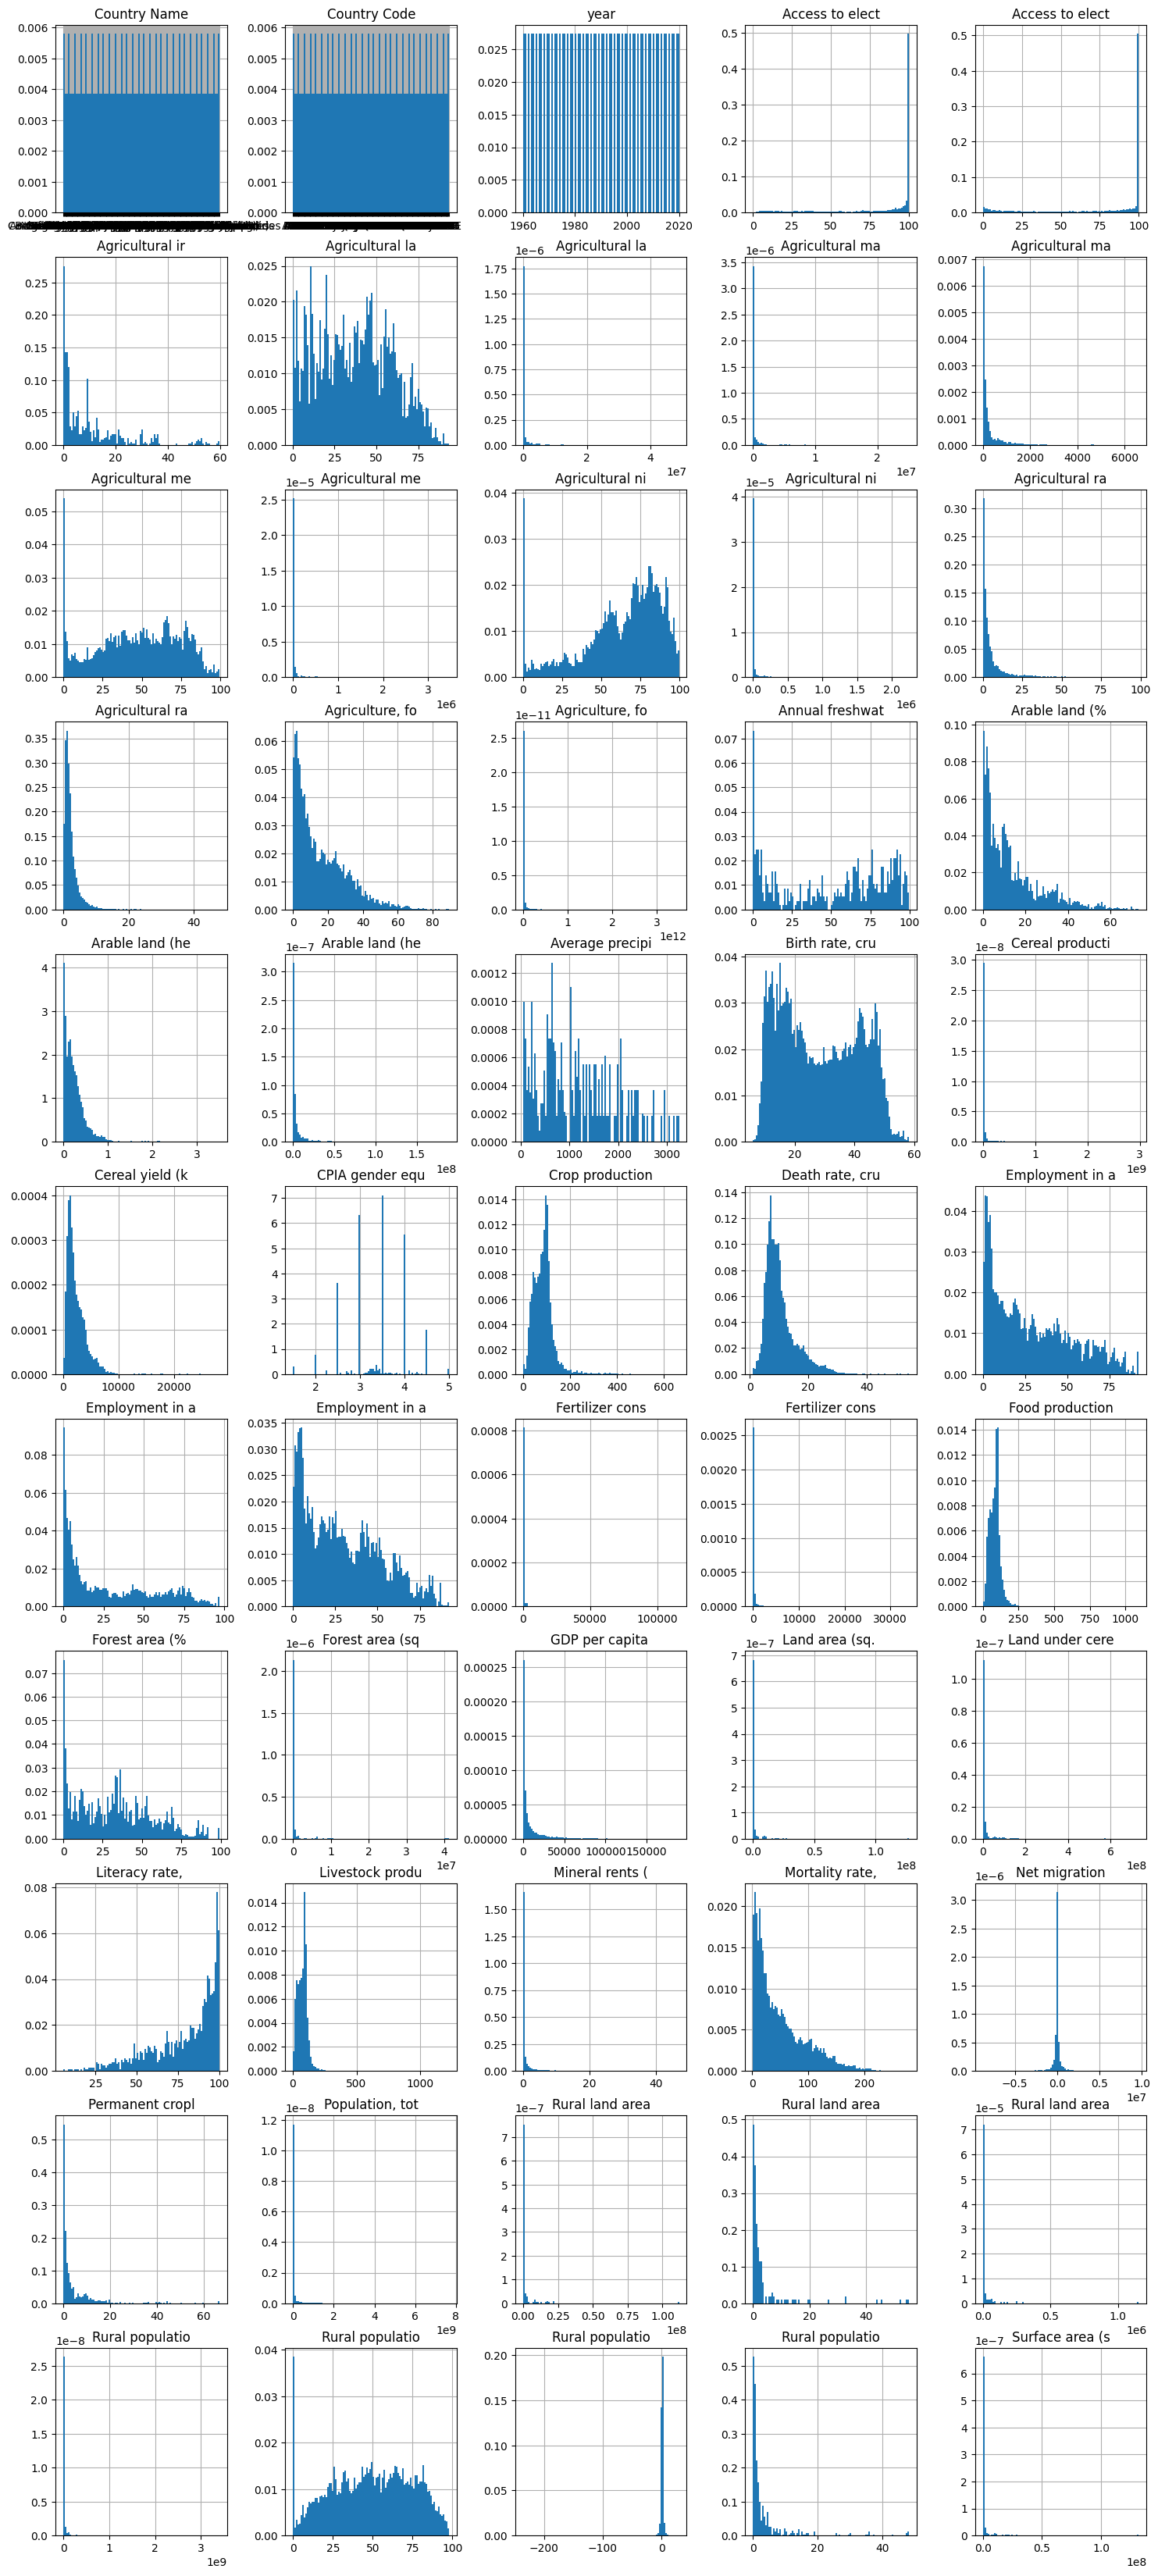

In [16]:
# varable distribution overview
alpha = 0.025

all_attributes_names = df_oig.columns.values

fig, axs = plt.subplots(11,5, figsize=(15,33))
fig.tight_layout(pad=2.0)
# fig.suptitle("distribution overview per feature")
for i, nam in enumerate(df_oig.columns.values):
    ax = axs[i//5, i%5]
    ax.set_title(all_attributes_names[i][0:15])
    ax.hist(df_oig[nam], bins=100, density=True)
    ax.set_axisbelow(True)
    ax.grid()


# Data Correlation Visualisation

/var/folders/3c/t08nl7456zl9jcq07p2xt7x80000gn/T/ipykernel_80634/3724694586.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_short.corr(), annot=False, vmax=1, vmin=-1)


<AxesSubplot: title={'center': 'Correlation plot'}>

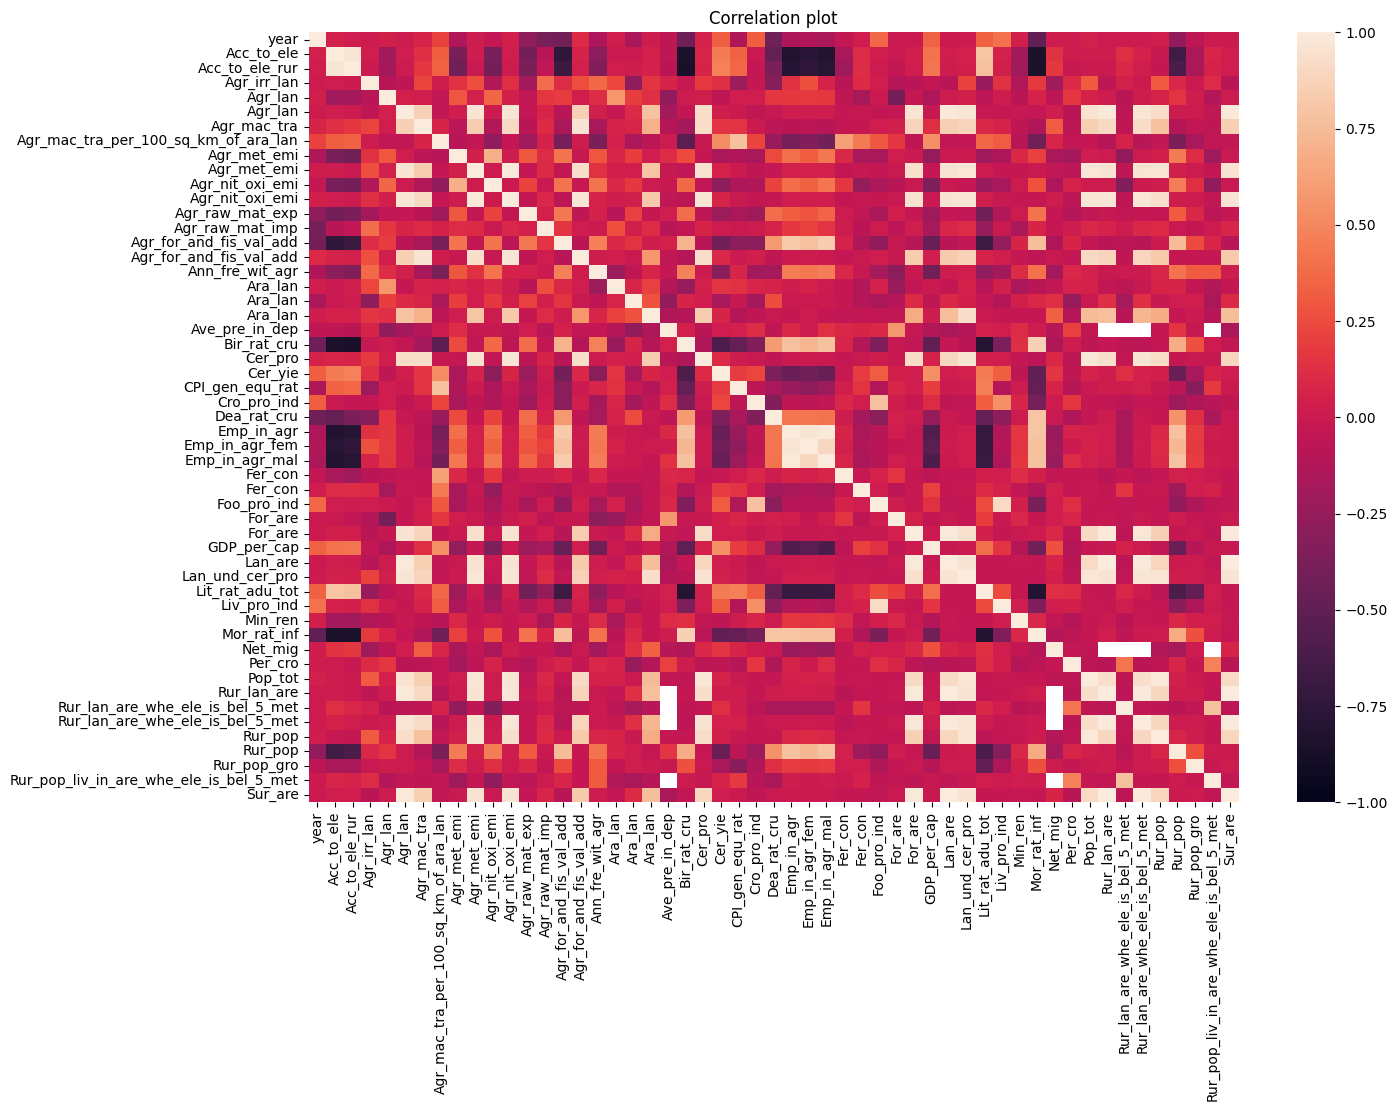

In [17]:
def process_name(name):
    name = name.split(' (')[0]\
        .replace(" ", "_")\
        .replace(',','')\
        .replace('.','')
    names = name.split('_')
    if len(names) < 2: return name[:6]
    names = [nam[:3] for nam in names]
    name = '_'.join(names)
    # print(name)
    return name

short_names = list(map(process_name, df_oig.columns.values))
df_short = df_oig.copy()
df_short.columns = short_names


# heatmap - correlation visualisation
plt.figure(figsize=(15,10))
plt.title("Correlation plot")
sns.heatmap(data=df_short.corr(), annot=False, vmax=1, vmin=-1)

/var/folders/3c/t08nl7456zl9jcq07p2xt7x80000gn/T/ipykernel_80634/2176888686.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_imputed.corr(), annot=False, vmax=1, vmin=-1)


<AxesSubplot: title={'center': 'Correlation plot'}>

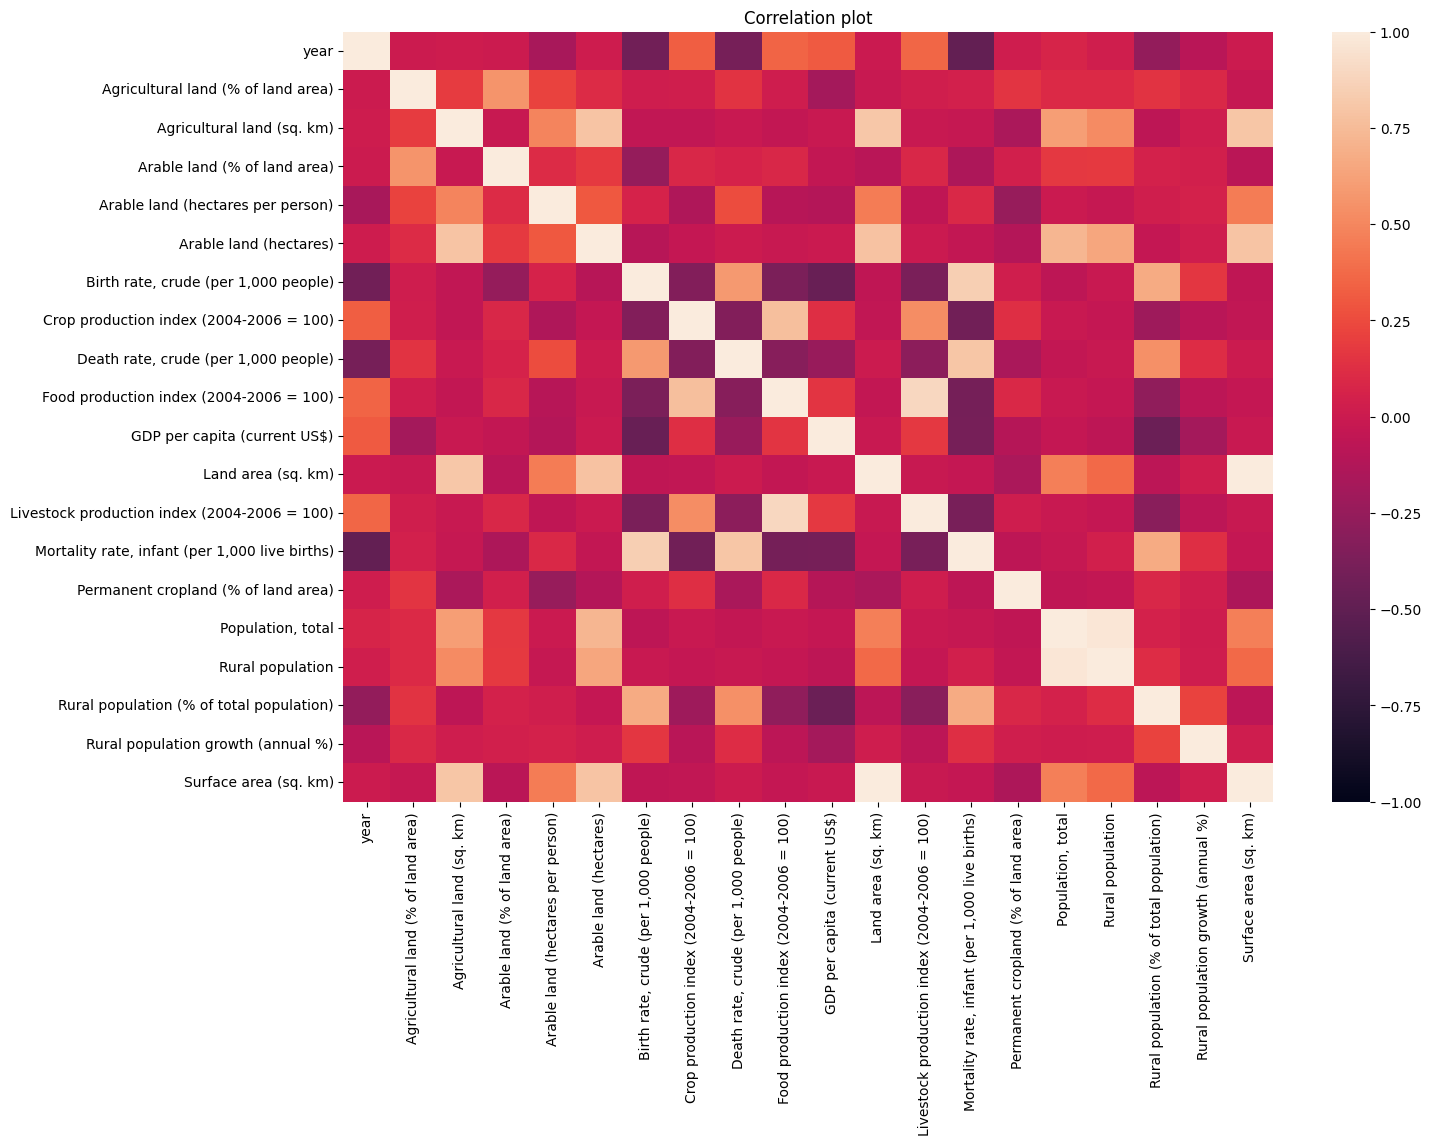

In [18]:
# heatmap - correlation visualisation
plt.figure(figsize=(15,10))
plt.title("Correlation plot")
sns.heatmap(data=df_imputed.corr(), annot=False, vmax=1, vmin=-1)

# Data Semantics Visualisation

In [19]:
# !pip install plotly

In [20]:
df_geo_vis = df_imputed.loc[df_imputed['year'] == 2000, ['Country Name', 'Population, total']]

In [21]:
# name mapping
new_names_map = {}
new_names_map['North Macedonia'] = 'North Macedonia'
new_names_map['Bosnia and Herzegovina'] = 'Bosnia and Herzegovina'
new_names_map['Slovak Republic'] = 'Slovakia'
new_names_map['Czech Republic'] = 'Czech Republic'
new_names_map['United Kingdom'] = 'United Kingdom'
new_names_map['Russian Federation'] = 'Russia'
def map_a_name(name):
    if name in new_names_map.keys():
        return new_names_map[name]
    return name

df_geo_vis['Country Name'] = df_geo_vis['Country Name'].apply(lambda x: map_a_name(x))


In [22]:
# Filtering
# print(json.dumps(geo_europe['features'][0]['properties']["name_en"], indent=2))

country_names_filter = ['Albania', 'Andorra', 'Armenia', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 
    'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'FaroeIslands', 'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Hungary', 
    'Iceland', 'Ireland', 'IsleofMan', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Moldova', 'Monaco', 
    'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'SanMarino', 
    'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom'
]

df_geo_vis = df_geo_vis.loc[df_geo_vis['Country Name'].isin(country_names_filter),]


In [23]:
import json
import plotly.express as px

geo_europe = json.load(open("./data/custom.geo.json", 'r'))

g_list = geo_europe['features']
# print(json.dumps(geo_europe, indent=2))

fig = px.choropleth(
    df_geo_vis, 
    geojson=geo_europe, 
    locations='Country Name', color='Population, total',
    featureidkey="properties.name_en",
    color_continuous_scale="Viridis",
    range_color=(0, df_geo_vis['Population, total'].max()),
    scope="europe",
    labels={'unemp':'unemployment rate'}
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


# ====================

In [24]:
import geopandas as gpd
df = px.data.election()
geo_df = gpd.GeoDataFrame.from_features(
    px.data.election_geojson()["features"]
).merge(df, on="district").set_index("district")


ModuleNotFoundError: No module named 'geopandas'

In [ ]:
df.head()

fips  unemp
0  01001    5.3
1  01003    5.4
2  01005    8.6
3  01007    6.6
4  01009    5.5

<AxesSubplot: >

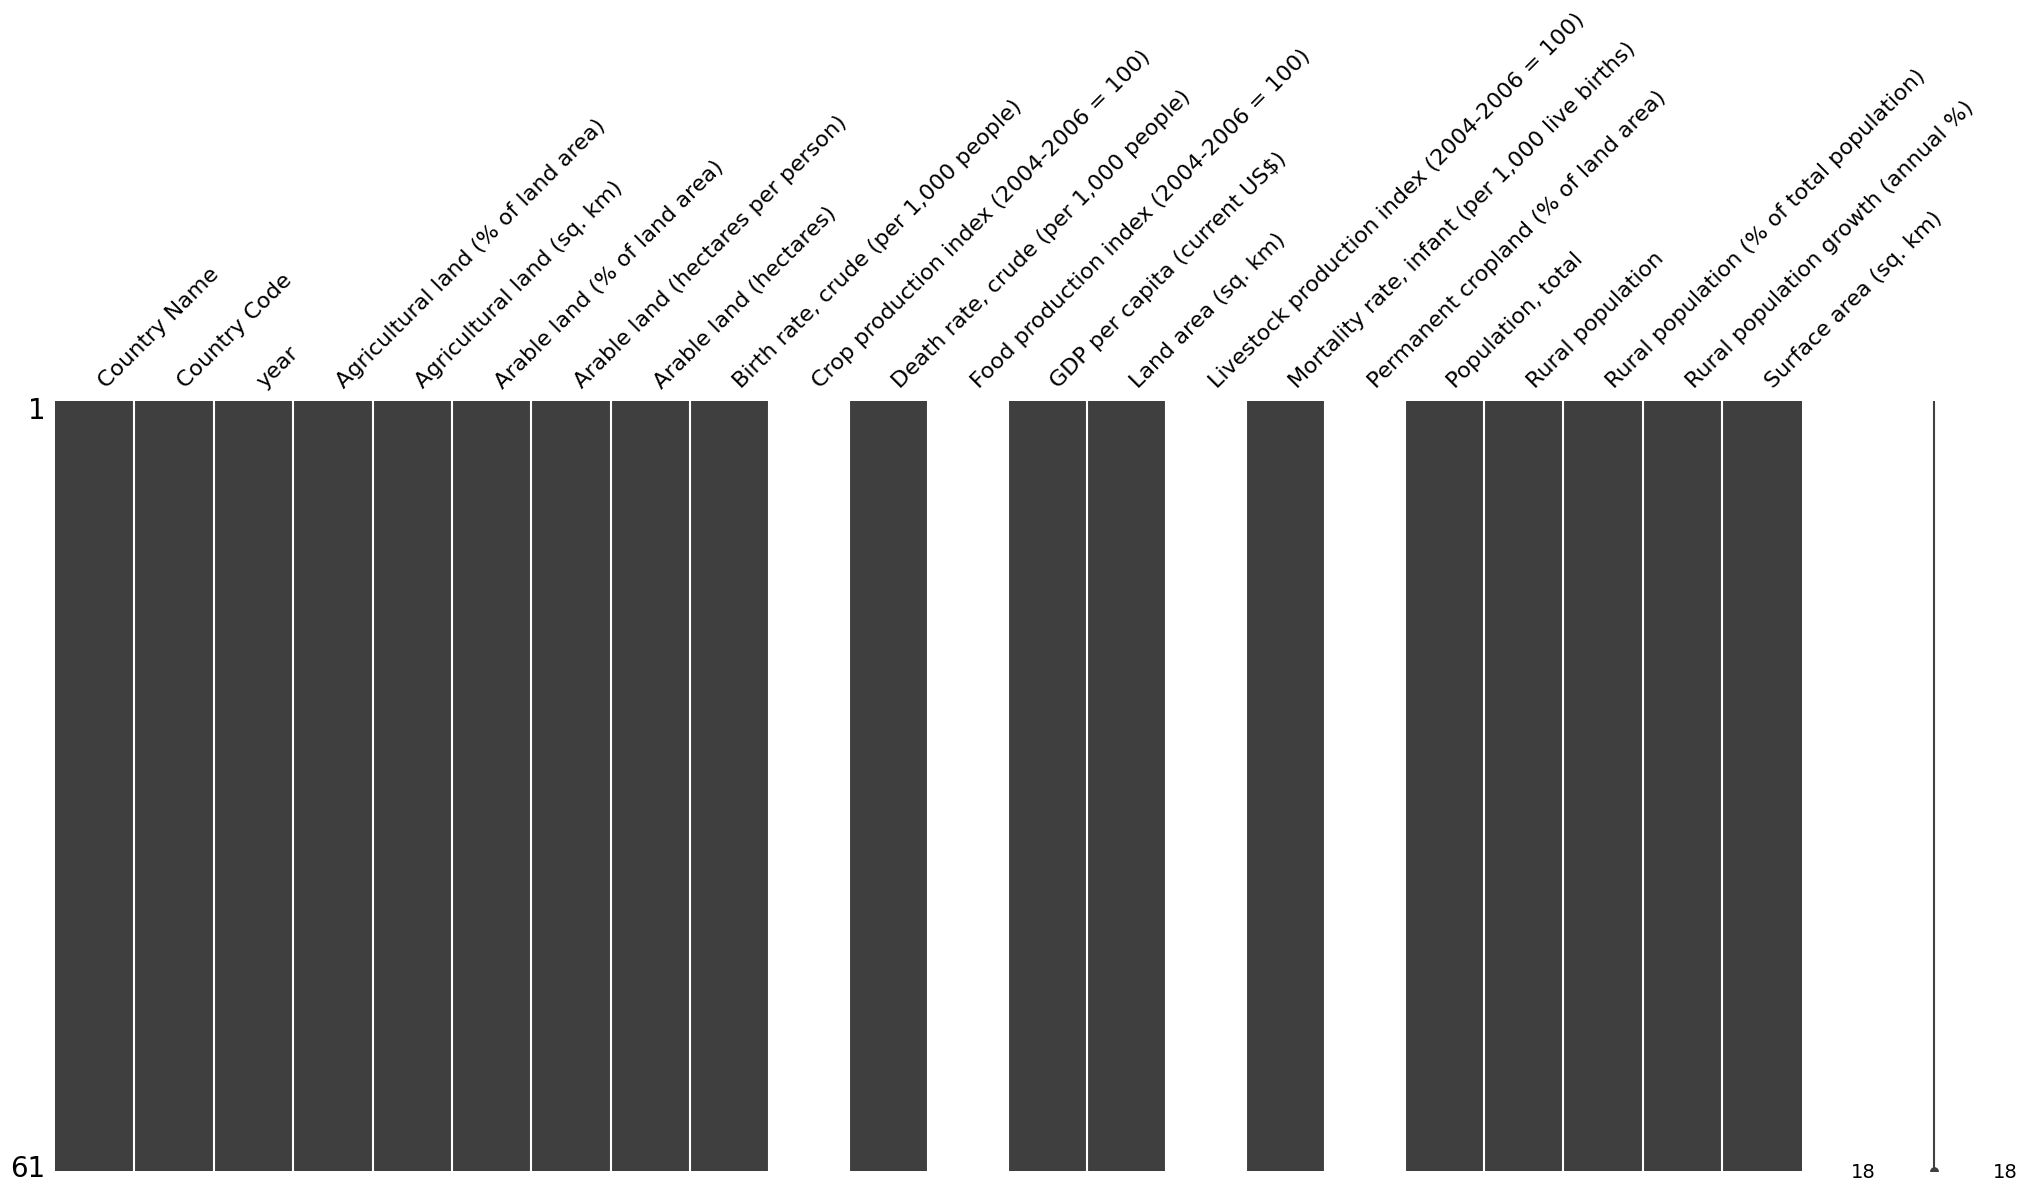

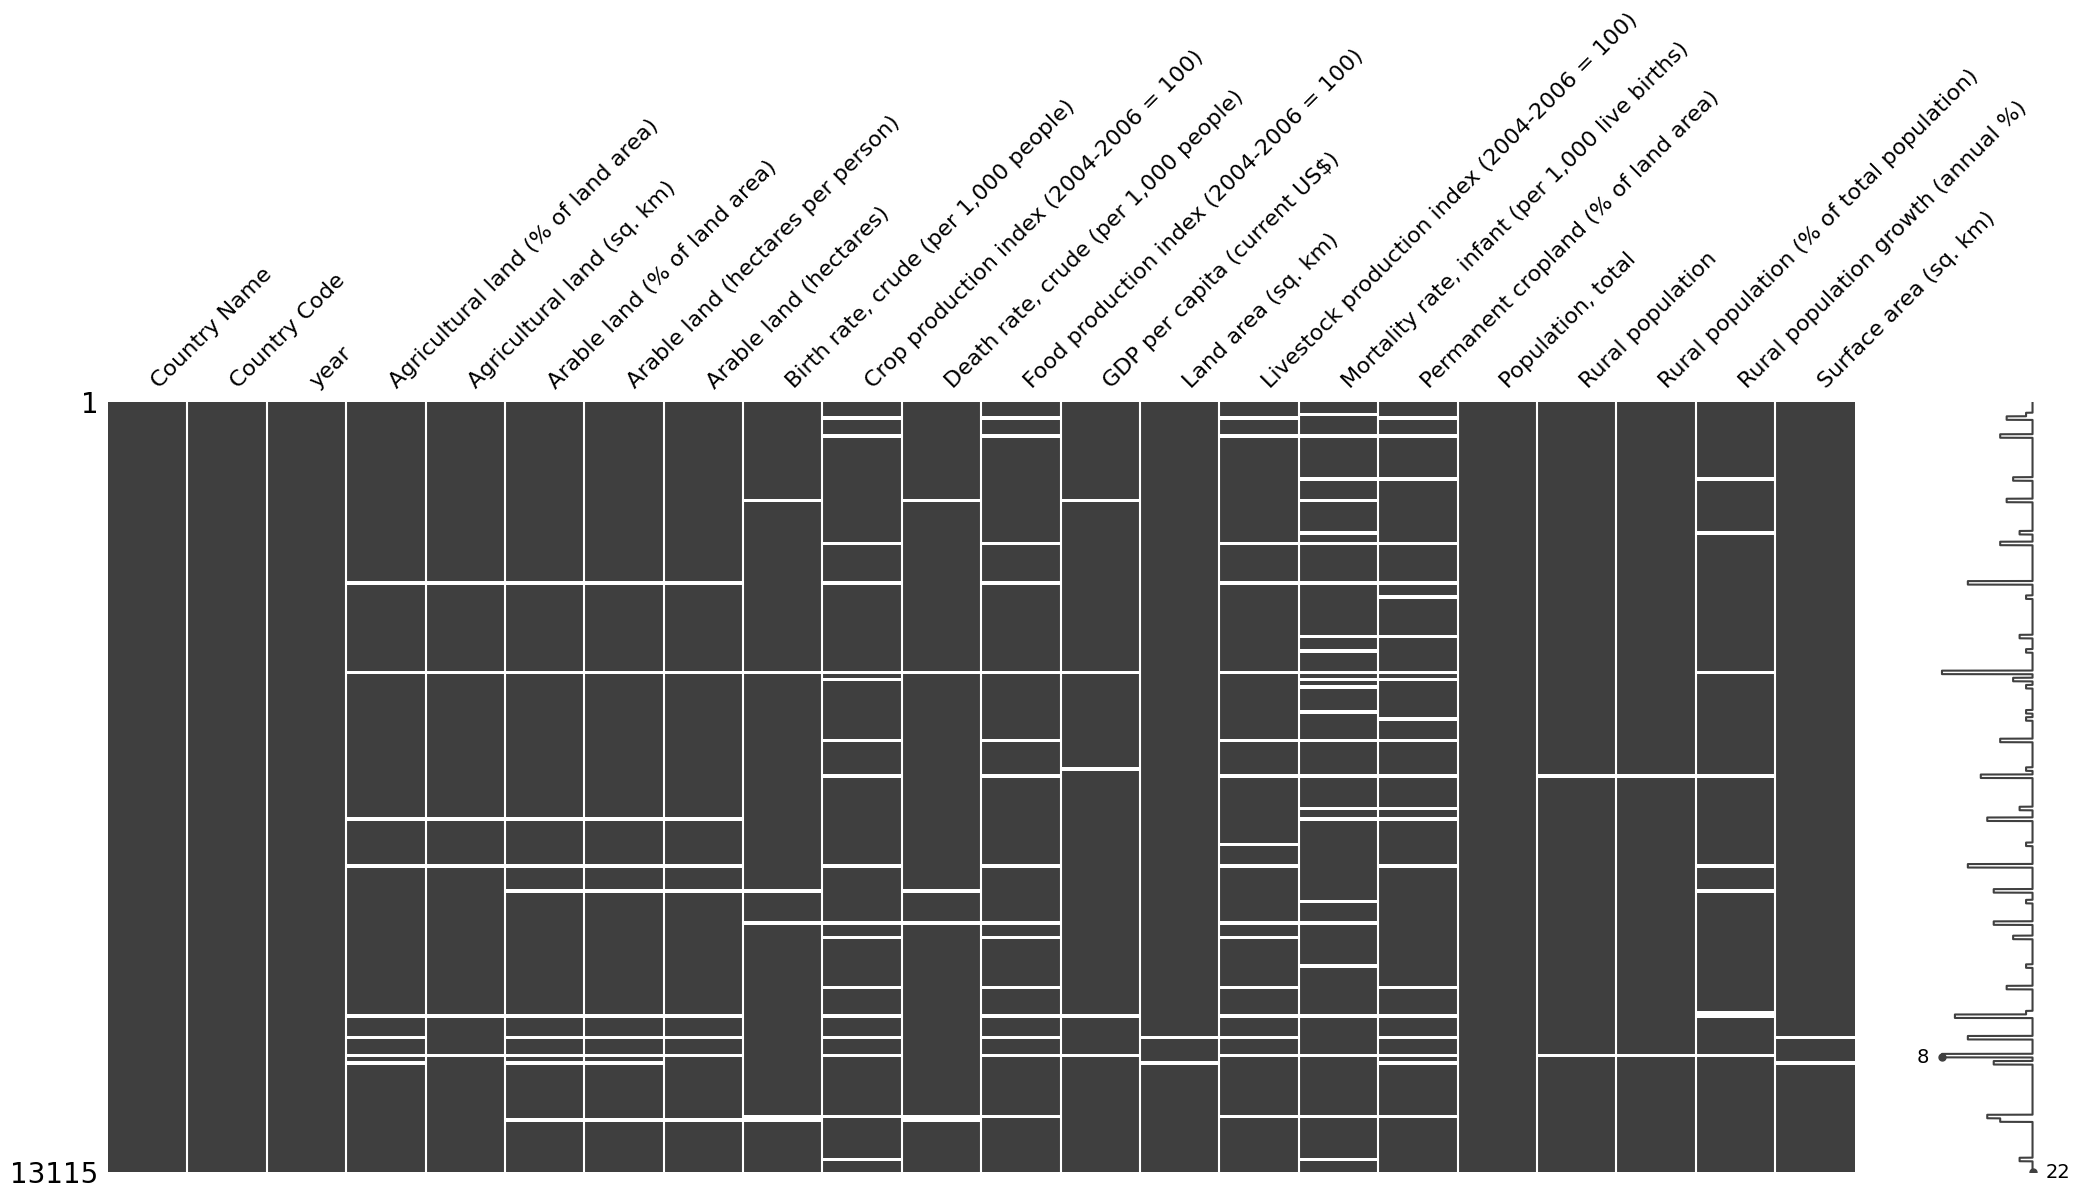

In [ ]:
# df_grouped = df_selected.groupby("Country Name", group_keys=True)


country_names = sorted(list(set(df_selected["Country Name"])))
for cn in country_names:
    selected = df_selected.loc[df_selected["Country Name"] == cn,:]
    # print(selected.shape, selected['Country Name'].iloc[0])
    solution = df_selected.loc[df_selected["Country Name"] == cn,:].apply(lambda x: myImputation(x), axis=0)
    df_selected.loc[df_selected["Country Name"] == cn,:] = solution
msno.matrix(df_selected.loc[df_selected["Country Name"] == country_names[4],:])
msno.matrix(df_selected)


In [1]:
biggest_countries = cleaned.sort_values(by=f"Agricultural land (% of land area)", axis=0, ascending=False).loc[data["year"]==2000]
biggest_countries = biggest_countries[:10]
fig = plt.figure()

plt.bar(biggest_countries["Country Name"],
       biggest_countries[f"Agricultural land (% of land area)"])
#plt.show()

NameError: name 'cleaned' is not defined

In [ ]:
# shorten column names
names = df.columns.values

def process_name(name):
    name = name.split(' (')[0]\
        .replace(" ", "_")\
        .replace(',','')\
        .replace('.','')
    names = name.split('_')
    if len(names) < 2: return name[:6]
    names = [nam[:3] for nam in names]
    name = '_'.join(names)
    # print(name)
    return name

short_names = list(map(process_name, names))

# df.columns = short_names

In [ ]:
print(len(string))
string = """
______ _ , - - . _ . - ,
______/ \ _ r - , \ _  )
. - . )   _ ; = ' _ /   ( . ;
____\   \\ '---------\ / S  )
_____L . ' - .   _ . ' | - '
__< _ ` - ' \\ ' _ . ' /
_______` ' - . _ ( \\
_______ _ _ _       \\\ ,             _ _ _
_______\   . ' - .   \\\       . - ' _ .   /
________' . _ '   ' . \\ \ / . - ' _ . '
_____________' - - ` ` \ ( ' - - '
________________________\\\\
_______ 1 / 1 0 0 ______`\\\,
__________________________\|
"""
string = string.replace('  ', 'XX')
print(string)


string_2 = string.split()
print(' '.join(string_2))

431

______ _ , - - . _ . - ,
______/ \ _ r - , \ _XX)
. - . )XX _ ; = ' _ /XX ( . ;
____\XX \ '---------\ / SXX)
_____L . ' - .XX _ . ' | - '
__< _ ` - ' \ ' _ . ' /
_______` ' - . _ ( \
_______ _ _ _XXXXXX \\ ,XXXXXXXXXXXX _ _ _
_______\XX . ' - .XX \\XXXXXX . - ' _ .XX /
________' . _ 'XX ' . \ \ / . - ' _ . '
_____________' - - ` ` \ ( ' - - '
________________________\\
_______ 1 / 1 0 0 ______`\\,
__________________________\|

______ _ , - - . _ . - , ______/ \ _ r - , \ _XX) . - . )XX _ ; = ' _ /XX ( . ; ____\XX \ '---------\ / SXX) _____L . ' - .XX _ . ' | - ' __< _ ` - ' \ ' _ . ' / _______` ' - . _ ( \ _______ _ _ _XXXXXX \\ ,XXXXXXXXXXXX _ _ _ _______\XX . ' - .XX \\XXXXXX . - ' _ .XX / ________' . _ 'XX ' . \ \ / . - ' _ . ' _____________' - - ` ` \ ( ' - - ' ________________________\\ _______ 1 / 1 0 0 ______`\\, __________________________\|
